### Team 7: Gandhimathi, Valli, Sharath, Sai Vathan 

### Load and Preprocess Data

In [1]:
#pip install sentence-transformers

In [2]:
#pip install tf-keras

In [3]:
#pip install flask

In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from flask import Flask, request, jsonify
from spellchecker import SpellChecker
from transformers import pipeline
from nltk.corpus import wordnet

In [5]:
# Load dataset
data = pd.read_csv("data.csv")

### Exploratory Data Analysis (EDA)

First five rows of the dataset:
          isbn13      isbn10           title subtitle  \
0  9780002005883  0002005883          Gilead      NaN   
1  9780002261982  0002261987    Spider's Web  A Novel   
2  9780006163831  0006163831    The One Tree      NaN   
3  9780006178736  0006178731  Rage of angels      NaN   
4  9780006280897  0006280897  The Four Loves      NaN   

                           authors                     categories  \
0               Marilynne Robinson                        Fiction   
1  Charles Osborne;Agatha Christie  Detective and mystery stories   
2             Stephen R. Donaldson               American fiction   
3                   Sidney Sheldon                        Fiction   
4              Clive Staples Lewis                 Christian life   

                                           thumbnail  \
0  http://books.google.com/books/content?id=KQZCP...   
1  http://books.google.com/books/content?id=gA5GP...   
2  http://books.google.com/books/content?i

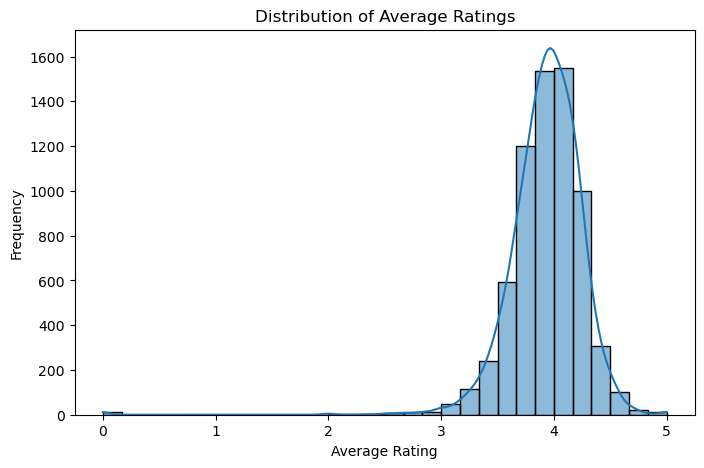

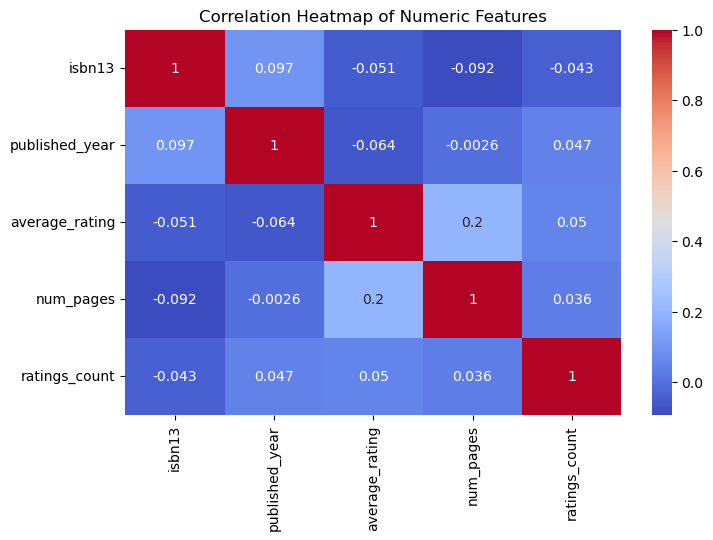

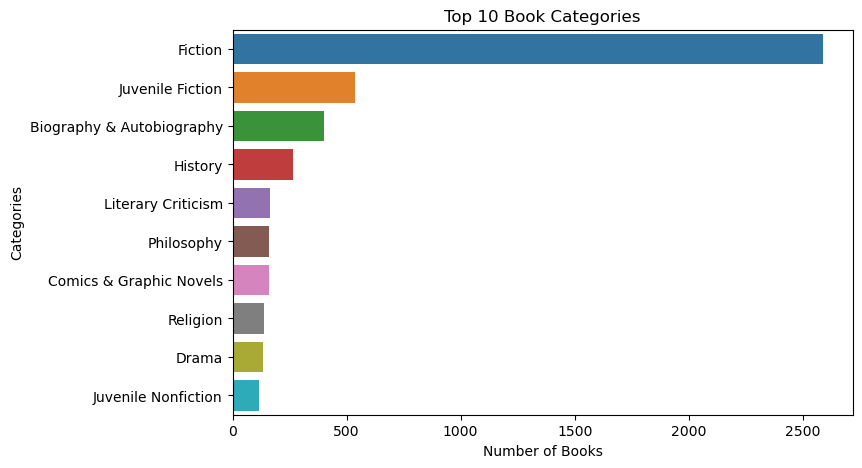

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Initial Exploration
print("First five rows of the dataset:")
print(data.head())
print("\nShape of the dataset:")
print(data.shape)

# Missing Values Analysis
print("\nMissing values count per column:")
print(data.isnull().sum())

# Summary Statistics
print("\nStatistical summary of numeric columns:")
print(data.describe())

# Distribution of Average Ratings
plt.figure(figsize=(8, 5))
sns.histplot(data['average_rating'].dropna(), kde=True, bins=30)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(8, 5))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Most Common Categories (if present)
if 'categories' in data.columns:
    all_categories = data['categories'].dropna().str.split(',').sum()
    category_counts = Counter([category.strip() for category in all_categories])
    top_categories = category_counts.most_common(10)

    # Bar Plot for Categories
    plt.figure(figsize=(8, 5))
    sns.barplot(x=[count[1] for count in top_categories], y=[count[0] for count in top_categories])
    plt.title('Top 10 Book Categories')
    plt.xlabel('Number of Books')
    plt.ylabel('Categories')
    plt.show()
else:
    print("No 'categories' column found in the dataset.")

### Preprocessing Data

In [7]:
# Replace 'Unknown' with NaN globally
data.replace('Unknown', np.nan, inplace=True)

# Handling Missing Data
data['authors'] = data['authors'].fillna('Unknown Author')
data['categories'] = data['categories'].fillna('Unknown Category')
data['description'] = data['description'].fillna('Description Not Available')

# Impute numerical missing values with median
num_cols = ['average_rating', 'num_pages', 'ratings_count']
for col in num_cols:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())

# Convert `published_year` to numeric and handle missing/invalid values
if 'published_year' in data.columns:
    data['published_year'] = pd.to_numeric(data['published_year'], errors='coerce')
    data['published_year'] = data['published_year'].fillna(-1).astype(int)

In [8]:
# Data Cleaning
def clean_text(text):
    """Clean text by removing special characters and converting to lowercase."""
    if pd.isnull(text):
        return ""
    text = re.sub(r'\W+', ' ', text)
    return text.lower().strip()

data['description'] = data['description'].apply(clean_text)
data['categories'] = data['categories'].apply(clean_text)
data['title'] = data['title'].apply(clean_text)

In [9]:
# Combine relevant fields for feature representation
data['combined_features'] = data['title'] + " " + data['description'] + " " + data['categories']

In [10]:
# Initialize Tools
spell = SpellChecker()
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

Device set to use mps:0


### TF-IDF-Based Content Filtering

In [11]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_features'])

def recommend_books_tfidf(query, top_n=5):
    """Recommend books based on a query using TF-IDF and cosine similarity."""
    query = clean_text(query)  # Clean the user query
    query_vec = tfidf_vectorizer.transform([query])  # Vectorize the query
    similarity_scores = cosine_similarity(query_vec, tfidf_matrix)  # Compute similarity
    similar_books_indices = similarity_scores.argsort()[0, -top_n:][::-1]  # Get top N indices
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']]

### Semantic Search with BERT

In [12]:
# Generate BERT embeddings
data['bert_embeddings'] = list(bert_model.encode(data['combined_features'].tolist(), show_progress_bar=True))

def recommend_books_bert(query, top_n=5):
    """Recommend books using BERT embeddings and cosine similarity."""
    query_embedding = bert_model.encode([query])[0]  # Generate query embedding
    similarity_scores = cosine_similarity([query_embedding], list(data['bert_embeddings']))
    similar_books_indices = similarity_scores.argsort()[0, -top_n:][::-1]  # Get top N indices
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']]

Batches:   0%|          | 0/213 [00:00<?, ?it/s]

### Topic Modeling with LDA

In [13]:
# Convert text to Bag-of-Words (BoW)
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
bow_matrix = vectorizer.fit_transform(data['combined_features'])

In [14]:
# Apply LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # Set n_components as the number of topics
lda_model.fit(bow_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [15]:
# Assign the most probable topic to each book
topic_distribution = lda_model.transform(bow_matrix)
data['topic'] = topic_distribution.argmax(axis=1)

In [16]:
def recommend_books_by_topic(query_topic, top_n=5):
    """Recommend books based on a specific topic."""
    filtered_books = data[data['topic'] == query_topic]
    return filtered_books[['title', 'authors', 'categories', 'average_rating']].head(top_n)

### Query Expansion

In [17]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sharathmohan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
def expand_query(query):
    """Expand the query by adding synonyms for each word."""
    expanded_query = []
    for word in query.split():
        synonyms = [syn.lemmas()[0].name() for syn in wordnet.synsets(word)]
        expanded_query.extend(synonyms[:3])  # Limit to top 3 synonyms
    return " ".join(set(expanded_query))

In [19]:
# Example Usage
query = "adventure fiction"
expanded_query = expand_query(query)
print(expanded_query)

fiction gamble adventure fabrication venture


### Sentiment Analysis

In [20]:
def analyze_sentiment(query):
    """Analyze the sentiment of a user's query."""
    return emotion_analyzer(query)[0]['label']

In [21]:
# Example Usage
query = "I feel sad and need something uplifting."
sentiment = analyze_sentiment(query)
print(sentiment)  # Output: 'positive'

sadness


### Hybrid Recommendations

In [22]:
def hybrid_recommendation(query, user_topic, weight_tfidf=0.5, weight_bert=0.5, top_n=5):
    """Combine TF-IDF, BERT, and topic information for hybrid recommendations."""
    query = expand_query(query)  # Expand the query
    tfidf_scores = cosine_similarity(tfidf_vectorizer.transform([query]), tfidf_matrix)[0]
    query_embedding = bert_model.encode([query])[0]
    bert_scores = cosine_similarity([query_embedding], list(data['bert_embeddings']))[0]
    topic_scores = (data['topic'] == user_topic).astype(int)
    combined_scores = weight_tfidf * tfidf_scores + weight_bert * bert_scores + 0.1 * topic_scores
    similar_books_indices = combined_scores.argsort()[-top_n:][::-1]
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']]

### RoBERTa

In [23]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load RoBERTa model
roberta_model = SentenceTransformer('stsb-roberta-base')

# Generate embeddings
data['roberta_embeddings'] = list(roberta_model.encode(data['description'].tolist(), show_progress_bar=True))

def recommend_books_roberta(query, top_n=5):
    query_embedding = roberta_model.encode([query])[0]
    similarity_scores = cosine_similarity([query_embedding], list(data['roberta_embeddings']))
    similar_books_indices = similarity_scores.argsort()[0, -top_n:][::-1]
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']]

Batches:   0%|          | 0/213 [00:00<?, ?it/s]

### DistilBERT

In [24]:
# Use DistilBERT in the same way as BERT or RoBERTa
distilbert_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Generate embeddings
data['distilbert_embeddings'] = list(distilbert_model.encode(data['description'].tolist(), show_progress_bar=True))

def recommend_books_distilbert(query, top_n=5):
    query_embedding = distilbert_model.encode([query])[0]
    similarity_scores = cosine_similarity([query_embedding], list(data['distilbert_embeddings']))
    similar_books_indices = similarity_scores.argsort()[0, -top_n:][::-1]
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']]

Batches:   0%|          | 0/213 [00:00<?, ?it/s]

### BM25 (Okapi BM25)

In [25]:
#pip install rank-bm25

In [26]:
from rank_bm25 import BM25Okapi

# Ensure 'description' column is filled and converted to strings
data['description'] = data['description'].fillna('No description available').astype(str)

# Tokenize corpus
tokenized_corpus = [desc.split() for desc in data['description'].tolist()]
bm25 = BM25Okapi(tokenized_corpus)

def recommend_books_bm25(query, top_n=5):
    tokenized_query = query.split()
    scores = bm25.get_scores(tokenized_query)
    similar_books_indices = scores.argsort()[-top_n:][::-1]
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']]

### Word2Vec

In [27]:
# Generate Word2Vec embeddings for all rows
def generate_w2v_embeddings(data, model):
    """
    Generate Word2Vec embeddings for book descriptions.

    Args:
        data (pd.DataFrame): Dataset containing book descriptions.
        model (Word2Vec): Trained Word2Vec model.

    Returns:
        pd.DataFrame: Updated dataset with embeddings.
    """
    tokenized_descriptions = [desc.split() if isinstance(desc, str) else [] for desc in data['description']]
    vector_size = model.vector_size

    data['w2v_embeddings'] = [
        np.mean(
            [model.wv[word] for word in tokens if word in model.wv],
            axis=0
        ) if tokens else np.zeros(vector_size)
        for tokens in tokenized_descriptions
    ]
    return data

In [28]:
# Ensure all embeddings are valid and consistent
def validate_embeddings(data, embedding_column, vector_size):
    """
    Validate and fix embeddings for consistency.

    Args:
        data (pd.DataFrame): Dataset containing embeddings.
        embedding_column (str): Column name containing embeddings.
        vector_size (int): Expected size of the embeddings.

    Returns:
        pd.DataFrame: Dataset with validated embeddings.
    """
    valid_embeddings = []
    for embedding in data[embedding_column]:
        if isinstance(embedding, np.ndarray) and embedding.shape == (vector_size,):
            valid_embeddings.append(embedding)
        else:
            valid_embeddings.append(np.zeros(vector_size))  # Fill with zero vector if invalid
    data[embedding_column] = valid_embeddings
    return data

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_books_w2v(query, data, model, top_n=5):
    """
    Recommend books based on Word2Vec embeddings.

    Args:
        query (str): User query.
        data (pd.DataFrame): Dataset containing embeddings.
        model (Word2Vec): Trained Word2Vec model.
        top_n (int): Number of recommendations to return.

    Returns:
        list: List of recommended books.
    """
    # Ensure query vector is valid
    query_vec = np.mean([model.wv[word] for word in query.split() if word in model.wv], axis=0)
    if query_vec.shape != (model.vector_size,):
        query_vec = np.zeros(model.vector_size)

    # Compute cosine similarity
    embeddings_matrix = np.stack(data['w2v_embeddings'])
    similarity_scores = cosine_similarity([query_vec], embeddings_matrix)
    similar_books_indices = similarity_scores.argsort()[0, -top_n:][::-1]
    
    # Return recommendations
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']].to_dict(orient='records')

In [30]:
from gensim.models import Word2Vec

tokenized_descriptions = [desc.split() for desc in data['description'].fillna('').tolist()]
w2v_model = Word2Vec(tokenized_descriptions, vector_size=100, window=5, min_count=1, sg=1)

# Generate and validate embeddings
data = generate_w2v_embeddings(data, w2v_model)
data = validate_embeddings(data, 'w2v_embeddings', w2v_model.vector_size)

### FastText

In [31]:
def generate_fasttext_embeddings(data, model):
    """
    Generate FastText embeddings for book descriptions.

    Args:
        data (pd.DataFrame): Dataset containing book descriptions.
        model (FastText): Trained FastText model.

    Returns:
        pd.DataFrame: Updated dataset with embeddings.
    """
    tokenized_descriptions = [desc.split() if isinstance(desc, str) else [] for desc in data['description']]
    vector_size = model.vector_size

    data['fasttext_embeddings'] = [
        np.mean(
            [model.wv[word] for word in tokens if word in model.wv],
            axis=0
        ) if tokens else np.zeros(vector_size)
        for tokens in tokenized_descriptions
    ]
    return data

In [32]:
def validate_fasttext_embeddings(data, embedding_column, vector_size):
    """
    Validate and ensure consistent FastText embeddings.

    Args:
        data (pd.DataFrame): Dataset containing embeddings.
        embedding_column (str): Column name containing embeddings.
        vector_size (int): Expected size of the embeddings.

    Returns:
        pd.DataFrame: Dataset with validated embeddings.
    """
    valid_embeddings = []
    for embedding in data[embedding_column]:
        if isinstance(embedding, np.ndarray) and embedding.shape == (vector_size,):
            valid_embeddings.append(embedding)
        else:
            valid_embeddings.append(np.zeros(vector_size))  # Fill with zero vector if invalid
    data[embedding_column] = valid_embeddings
    return data

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_books_fasttext(query, data, model, top_n=5):
    """
    Recommend books based on FastText embeddings.

    Args:
        query (str): User query.
        data (pd.DataFrame): Dataset containing embeddings.
        model (FastText): Trained FastText model.
        top_n (int): Number of recommendations to return.

    Returns:
        list: List of recommended books.
    """
    # Generate query vector
    query_vec = np.mean([model.wv[word] for word in query.split() if word in model.wv], axis=0)
    if query_vec.shape != (model.vector_size,):
        query_vec = np.zeros(model.vector_size)

    # Compute cosine similarity
    embeddings_matrix = np.stack(data['fasttext_embeddings'])
    similarity_scores = cosine_similarity([query_vec], embeddings_matrix)
    similar_books_indices = similarity_scores.argsort()[0, -top_n:][::-1]

    # Return recommendations
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']].to_dict(orient='records')

In [34]:
from gensim.models import FastText

tokenized_descriptions = [desc.split() for desc in data['description'].fillna('').tolist()]
fasttext_model = FastText(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, sg=1)

# Generate and validate embeddings
data = generate_fasttext_embeddings(data, fasttext_model)
data = validate_fasttext_embeddings(data, 'fasttext_embeddings', fasttext_model.vector_size)

### Doc2Vec

In [35]:
def recommend_books_doc2vec(query, data, model, top_n=5):
    """
    Recommend books based on Doc2Vec embeddings.

    Args:
        query (str): User query.
        data (pd.DataFrame): Dataset containing book descriptions.
        model (Doc2Vec): Trained Doc2Vec model.
        top_n (int): Number of recommendations to return.

    Returns:
        list: List of recommended books.
    """
    # Generate query vector
    query_vec = model.infer_vector(query.split())

    # Find most similar documents
    similar_docs = model.dv.most_similar([query_vec], topn=top_n)

    # Extract indices and retrieve recommendations
    similar_books_indices = [int(doc_id) for doc_id, _ in similar_docs]
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']].to_dict(orient='records')

In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Prepare tagged documents
tagged_data = [
    TaggedDocument(words=desc.split(), tags=[str(idx)])
    for idx, desc in enumerate(data['description'].fillna(''))
]

# Train the model
doc2vec_model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, epochs=20)

### Zero-Shot Classification

In [37]:
from transformers import pipeline

# Load Zero-Shot Classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def recommend_books_zero_shot(query, candidate_labels):
    scores = []
    for desc in data['description']:
        result = classifier(desc, candidate_labels)
        scores.append(max(result['scores']))
    similar_books_indices = np.argsort(scores)[::-1][:5]
    return data.iloc[similar_books_indices][['title', 'authors', 'categories', 'average_rating']]

Device set to use mps:0


### Graph-Based Approach

In [38]:
# Ensure 'authors' column is filled and converted to strings
data['authors'] = data['authors'].fillna('Unknown Author').astype(str)

import networkx as nx

G = nx.Graph()
for idx, row in data.iterrows():
    G.add_node(row['title'], type='book')
    for author in row['authors'].split(','):
        G.add_node(author.strip(), type='author')
        G.add_edge(row['title'], author.strip())

def recommend_books_graph(query_author, top_n=5):
    if query_author not in G:
        return f"No books found for author: {query_author}"
    neighbors = list(nx.neighbors(G, query_author))
    books = [node for node in neighbors if G.nodes[node]['type'] == 'book']
    return books[:top_n]

# Example Query
query_author = "Nora Roberts"
recommendations = recommend_books_graph(query_author, top_n=5)
print(f"Books by or connected to {query_author}:")
print(recommendations)

Books by or connected to Nora Roberts:
['the macgregors', 'dream makers', 'rebellion', 'time again', 'first impressions']


In [39]:
w2v_model.save("word2vec_model.model")

In [40]:
doc2vec_model.save("doc2vec_model.model")

### Flask API Integration

In [41]:
#pip install spellchecker

In [42]:
#pip install pyspellchecker

In [43]:
#pip install --upgrade jupyter_client jupyter_core

In [44]:
#pip install --upgrade ipykernel

In [45]:
#pip install --upgrade flask

In [ ]:
app = Flask(__name__)

@app.route('/recommend', methods=['POST'])
def recommend():
    """Handle book recommendation queries."""
    user_query = request.json.get('query')
    user_topic = request.json.get('topic', 0)  # Default topic is 0
    if not user_query:
        return jsonify({"error": "No query provided"}), 400

    # Correct and expand the query
    corrected_query = " ".join([spell.correction(word) for word in user_query.split()])
    expanded_query = expand_query(corrected_query)

    # Generate recommendations
    tfidf_recommendations = recommend_books_tfidf(expanded_query).to_dict(orient='records')
    bert_recommendations = recommend_books_bert(expanded_query).to_dict(orient='records')
    roberta_recommendations = recommend_books_roberta(expanded_query).to_dict(orient='records')
    distilbert_recommendations = recommend_books_distilbert(expanded_query).to_dict(orient='records')
    #bm25_recommendations = recommend_books_bm25(corrected_query, top_n=5)
    word2vec_recommendations = recommend_books_w2v(user_query, data, w2v_model, top_n=5)
    fasttext_recommendations = recommend_books_fasttext(query=user_query, data=data, model=fasttext_model, top_n=5)
    doc2vec_recommendations = recommend_books_doc2vec(user_query, data, doc2vec_model, top_n=5)
    #zero_shot_recommendations = recommend_books_zero_shot(corrected_query, candidate_labels=["fiction", "romance", "adventure"])
    graph_recommendations = recommend_books_graph(request.json.get('author', 'Unknown Author'), top_n=5)
    topic_recommendations = recommend_books_by_topic(user_topic).to_dict(orient='records')
    hybrid_recommendations = hybrid_recommendation(expanded_query, user_topic).to_dict(orient='records')

    return jsonify({
        "query": user_query,
        "corrected_query": corrected_query,
        "expanded_query": expanded_query,
        "tfidf_recommendations": tfidf_recommendations,
        "bert_recommendations": bert_recommendations,
        "roberta_recommendations": roberta_recommendations,
        "distilbert_recommendations": distilbert_recommendations,
        #"bm25_recommendations": bm25_recommendations,
        "word2vec_recommendations": word2vec_recommendations,
        "fasttext_recommendations": fasttext_recommendations,
        "doc2vec_recommendations": doc2vec_recommendations,
        #"zero_shot_recommendations": zero_shot_recommendations,
        "graph_recommendations": graph_recommendations,
        "topic_recommendations": topic_recommendations,
        "hybrid_recommendations": hybrid_recommendations
    })

if __name__ == "__main__":
    app.run(port=5001)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
[2024-12-09 14:13:49,246] ERROR in app: Exception on /recommend [POST]
Traceback (most recent call last):
  File "/Users/sharathmohan/anaconda3/lib/python3.11/site-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sharathmohan/anaconda3/lib/python3.11/site-packages/flask/app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sharathmohan/anaconda3/lib/python3.11/site-packages/flask/app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sharathmohan/anaconda3/lib/python3.11/site-packages/flask/app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

127.0.0.1 - - [09/Dec/2024 14:21:14] "POST /recommend HTTP/1.1" 500 -
[2024-12-09 14:21:21,702] ERROR in app: Exception on /recommend [POST]
Traceback (most recent call last):
  File "/Users/sharathmohan/anaconda3/lib/python3.11/site-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sharathmohan/anaconda3/lib/python3.11/site-packages/flask/app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sharathmohan/anaconda3/lib/python3.11/site-packages/flask/app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sharathmohan/anaconda3/lib/python3.11/site-packages/flask/app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^